In [1]:
from __future__ import division
import csv
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cmx
from mpl_toolkits.mplot3d import Axes3D
import json
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.cross_validation import train_test_split
import string
import math
from dota_function_definitions import create_dota_dataframe2, getSynergyFactor, getWinRateArray, predictWinRate
from dota_function_definitions import getWinRateOpposingTeamArray, getAdvantageFactor, predictWinRateRefined, suggestHero

In [2]:
with open('heroes.txt', mode='r') as infile:
    reader = csv.reader(infile)
    heroDict = {rows[0]:rows[1] for rows in reader}

In [3]:
dotaFrame = pd.read_csv('dotaFrame_20160229_to_20160306.csv', sep=',')

96,004 matches (Very High skill, all matchmaking modes) were collected between February 29, 2016 and March 6, 2016. The matches all occurred while the game was on patch 6.86d. We can use the pandas.groupby() function to quickly see how many matches of each game mode were played.

In [4]:
dotaFrame.groupby('Game Mode').sum()['Match Counter']

Game Mode
1     34575
2       425
3      2570
4      6522
5       834
12       36
13       15
16        4
18     1814
20       71
22    49138
Name: Match Counter, dtype: int64

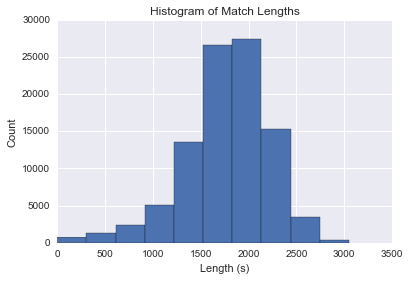

In [5]:
%matplotlib inline
ax = dotaFrame['Match Length (s)'].hist()
ax.set(xlabel='Length (s)', ylabel='Count', title='Histogram of Match Lengths')

All pick (game mode 1) and ranked all pick (game mode 22) provide the most freedom in picking heroes. In either mode, any player can pick any hero, so we will restrict our model to these two game modes. We will also eliminate games that end in under 10 minutes as that is generally indicative of something else happening (e.g. a player quitting the game early).

In [6]:
dotaFrame = pd.concat([dotaFrame[dotaFrame['Game Mode']==1], dotaFrame[dotaFrame['Game Mode']==22]])

In [7]:
dotaFrame = dotaFrame[dotaFrame['Match Length (s)']>599]

Scikit-learn's train_test_split() function allows us to easily split the data into a training set and a testing set. We'll use the training set to determine the model parameters and then use the testing set to see how effective the model is.

In [8]:
dotaFrameTrain, dotaFrameTest = train_test_split(dotaFrame, test_size = 0.2, random_state = 0)

In [9]:
len(dotaFrameTest)

16446

In [10]:
len(dotaFrameTrain)

65782

getWinRateArray() extracts the winrates as a 2D array where the diagonal terms are the individual winrates for each hero and the off-diagonal terms are winrates for when the two row/column heroes are on the same team together. By construction, this is a symmetric matrix.

In [11]:
winRateArray, matchCountArray = getWinRateArray(dotaFrameTrain)

[(0, 113),
 (1, 113),

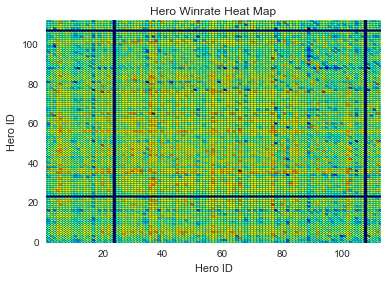

In [12]:
xCoordinate = range(1,114)*113
yCoordinate = range(1,114)*113
yCoordinate.sort()
zCoordinate = []
tempwrArray = list(winRateArray[1:])
for hero in tempwrArray:
    for i in range(1,114):
        zCoordinate.append(hero[i])
        
fig = plt.figure()
ax = fig.add_subplot(111)
cm = plt.get_cmap('jet')
cNorm = matplotlib.colors.Normalize(vmin=min(zCoordinate), vmax=max(zCoordinate))
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=cm)
ax.scatter(xCoordinate, yCoordinate, c=scalarMap.to_rgba(zCoordinate))
ax.set(xlabel='Hero ID', xlim=[1,113], ylabel='Hero ID', ylim=[0,113], title='Hero Winrate Heat Map')

The above heat map visualization of the win rate array gives us a sense of the data we are working with. The dark blue lines for heroes 24 and 108 indicate the reported 0% win rate for the two hero IDs that do not correspond to any heroes at all. In the heat map, striping patterns can be observed in the data, indicating that the win rates of a hero with other heroes is correlated to the individual win rate of that hero (which makes sense and is expected).

For the first iteration of this model, we compare the amount of synergy each team has by looking at winrates from past data. The team with the higher synergy is predicted to be the winner.

$$Synergy=\frac{\Sigma_{i=j}r_{ij}*a\log{N_{ij}}+\Sigma_{i\neq j}{r_{ij}*b\log{N_{ij}}}}{\Sigma_{i=j} a\log{N_{ij}}+ \Sigma_{i\neq j}b\log{N_{ij}}}$$

$i,j \in$ Team Heroes, $r_{ii}$ = Hero Winrate, $r_{ij}$ = Pairwise Winrate, $N_{ij}$ = Number of Games for Pair

We can test the model on the testing dataset for different values of b/a, noting that for the same b/a, the model has the same results (i.e. a=1, b=2 is the same model as a=2, b=4).

In [13]:
bParameter = np.linspace(0,15,61)
correctPredictions = []
for b in bParameter:
    correctPredictions.append(predictWinRate(dotaFrameTest, winRateArray, matchCountArray, b))

Best b: 14.0


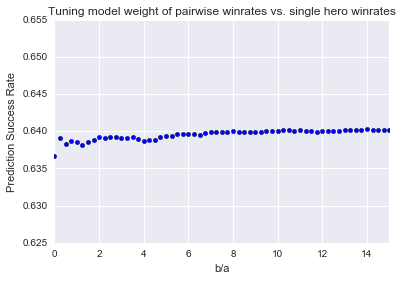

In [15]:
fig2 = plt.figure()
ax2 = fig2.add_subplot(111)
ax2.scatter(bParameter, correctPredictions)
ax2.set(xlabel='b/a', ylabel='Prediction Success Rate', xlim=[0,15])
ax2.set(title='Tuning model weight of pairwise winrates vs. single hero winrates')
print("Best b: %s" %(bParameter[correctPredictions.index(max(correctPredictions))]))

For increasing b/a, the model flatlines pretty quickly. Testing at higher values of b/a yields similar results at 64% successful prediction rates (against the training set). Compared to the case where only individual hero win rates were accounted for (b/a = 0, ~63.6%), there is a slight increase when taking into account synergistic factors from pairwise win rates. Next, we can take into account antagonistic relationships (the win rates when heroes are on opposing teams). We can use this data to create "advantage" factors for both teams which we will multiplicately apply to the synergy factors.

$$Advantage=\frac{\Sigma_{ij}d_{ij}\log{N_{ij}}}{\Sigma_{ij}\log{N_{ij}}}$$

$$d_{ij}=r_{ij}-(r_{ii}-r_{jj})$$

$i \in$ Team Heroes, $j ]in$ Enemy Heroes, $r_{ii}$ = Hero Winrate, $r_{ij}$ = Winrate of Hero i against Hero j, $N_{ij}$ = Number of Games for Pair

The model predicts victory for your team if:

$$Synergy_{YourTeam}Advantage_{YourTeam}>Synergy_{EnemyTeam}Advantage_{EnemyTeam}$$

In [16]:
opposingWinRateArray, opposingMatchCountArray = getWinRateOpposingTeamArray(dotaFrameTrain)

In [17]:
correctPredictionsRefined = []
for b in bParameter:
    correctPredictionsRefined.append(predictWinRateRefined(dotaFrameTest, winRateArray, matchCountArray, opposingWinRateArray, opposingMatchCountArray, b, 1))

Best b: 1.75


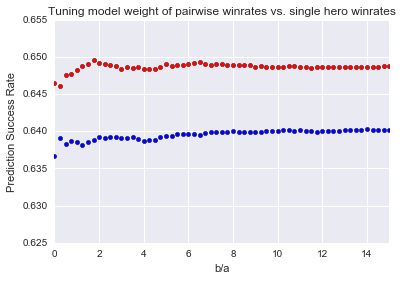

In [18]:
fig3 = plt.figure()
ax3 = fig3.add_subplot(111)
ax3.scatter(bParameter, correctPredictions)
ax3.scatter(bParameter, correctPredictionsRefined, c='red')
ax3.set(xlabel='b/a', ylabel='Prediction Success Rate', xlim=[0,15])
ax3.set(title='Tuning model weight of pairwise winrates vs. single hero winrates')
print("Best b: %s" %(bParameter[correctPredictionsRefined.index(max(correctPredictionsRefined))]))

Taking into account win rates when heroes are on opposing teams improves the model by ~1%. We can also further tune the model by changing the amount of impact the advantage factor has.
Your team wins if:

$$Synergy_{YourTeam}Advantage_{YourTeam}^C>Synergy_{EnemyTeam}Advantage_{EnemyTeam}^C$$

In [19]:
cParameter = np.linspace(0,4,41)
correctPredictionsRefined2 = []
for c in cParameter:
    correctPredictionsRefined2.append(predictWinRateRefined(dotaFrameTest, winRateArray, matchCountArray, opposingWinRateArray, opposingMatchCountArray, 1.75, c)) 

Best c: 2.6


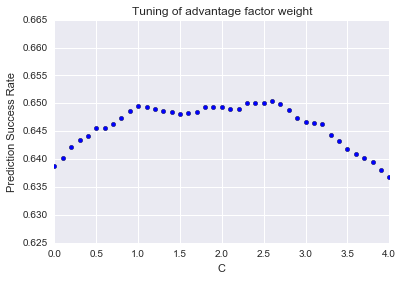

In [20]:
fig5 = plt.figure()
ax5 = fig5.add_subplot(111)
ax5.scatter(cParameter, correctPredictionsRefined2, c='blue')
ax5.set(xlabel='C', ylabel='Prediction Success Rate', xlim=[0,4])
ax5.set(title='Tuning of advantage factor weight')
print("Best c: %s" %(cParameter[correctPredictionsRefined2.index(max(correctPredictionsRefined2))]))

Using this model, we can also provide hero suggestions by finding heroes who both contribute to the team synergy and to the team advantage. For example, if you enemy team consists of [Alchemist, Sven, Warlock, Bloodseeker, Wraith King] and your team currently consists of [Lycanthrope, Abaddon, Luna, Zeus], the model can provide the potential hero picks to round out your team, giving you the best chance at victory.

In [23]:
yourT = [77,102,48,22]
enemyT = [73,18,37,4,42]
suggestHero(yourT, enemyT, winRateArray, matchCountArray, opposingWinRateArray, opposingMatchCountArray, heroDict, b=1.75, c=2.6)

Your team: lycan, abaddon, luna, zuus
Enemy team: alchemist, sven, warlock, bloodseeker, skeleton_king
Top 3 recommended heroes: omniknight, necrolyte, vengefulspirit


[57, 36, 20]